# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находятся в папке `/datasets/faces/`. 
В нашем распоряжении одна папка со всеми изображениями `(/final_files)` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

## Исследовательский анализ данных

Подгружаю необходимые библиотеки.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Извлеку данные из папки с помощью метода ImageDataGenerator — flow_from_dataframe() и поделю значения яркости на 255 с помощью аргумента rescale.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В датасете 7591 строка с наименованием изображений и возрастом соответствующим изображениям. Средний возраст людей на изображениях - 31 год.
Посмотрю на график распределения возраста в выборке.

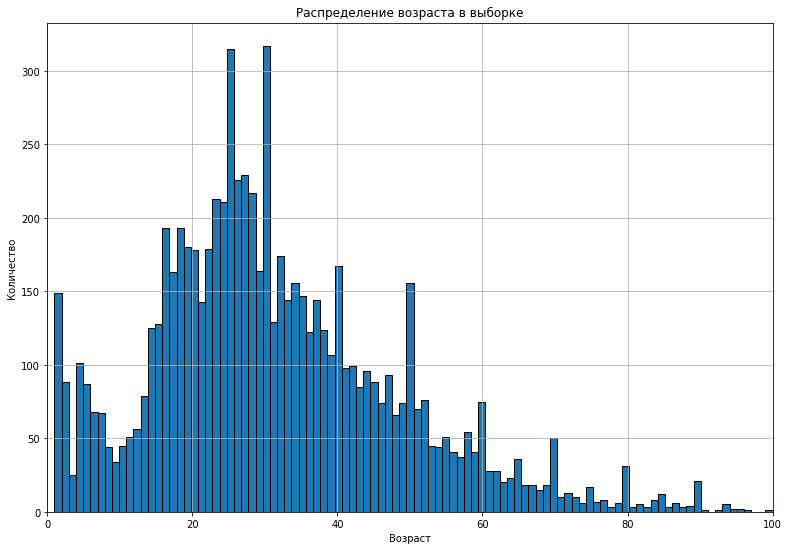

In [9]:
labels['real_age'].plot(kind='hist', bins=100, figsize=(13,9), grid=True, xlim=(0,100), edgecolor='k')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

In [14]:
labels['real_age'][(labels['real_age'] < 4).sum()]

31

В выборке присутствуют изображения с указанием возраста до 4-5 лет. Вероятнее всего это ошибка в данных, которая может не много снизить качество модели.

Выберу 12 случайных фотографий и выведу их на экран.

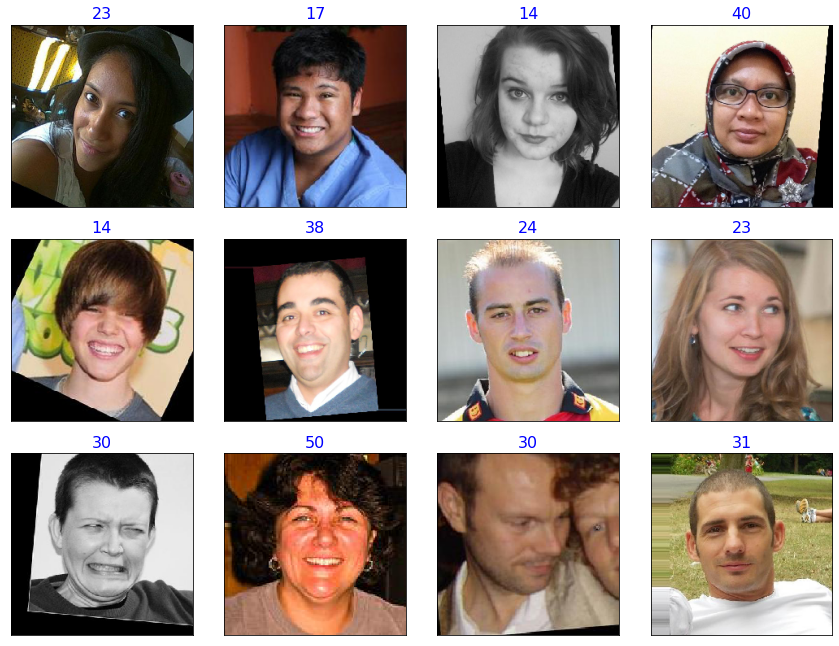

In [19]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i], fontsize = 16, color='blue')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

По выведенным фотографиям, можно заметить, что была проведена аугментация, присутствуют цветные и черно-белые фотографии, так же обрезанные и повернутые.

**Вывод:**

- Распределение возраста в датасете близко к нормальному, но присутствует небольшое количество аномальных значений в области до 5 лет, которые могут повлиять на качество модели.
- С фотографиями в исходном датасете уже проведена первичная аугментация.
- В датасете отсутствуют пропуски.
- Датасет содержит цветные и черно-белые фотографии лиц людей.
- Средний возраст людей на фотографиях, приерно 31 год.

## Обучение модели

Построю и обучю свёрточную нейронную сеть ResNet50, предобученную на датасете ImageNet, на датасете с фотографиями людей. Добьюсь значения MAE на тестовой выборке не больше 8.

- Напишу функции:
 - load_train(path) - загрузка тренировочного датасета,
 - load_test(path) - загрузка тестового датасета,
 - create_model(input_shape) - создание модели,
 - train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps) - обучение моделей. 
- Датасет разобью на тренировочную и тестовую выборку в соотношении 3:1.
- Размер батчей - 16.
- Использую полносвязный слой с функцией активации - `relu`.
- Для оптимизации использую алгоритм Adam со скоростью обучения - 0.0001.
- Функция потерь - MSE.
- Метрика качества - MAE.
- Количество эпох - 15.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                      vertical_flip=True, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path + 'final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'raw',
    subset = 'training',
    seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory = path + 'final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'raw',
    subset = 'validation',
    seed=42)
    return train_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

Результат обучения модели на 15 эпохах.

```

Train for 356 steps, validate for 119 steps
Epoch 1/15
2023-04-07 13:00:01.588977: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-07 13:00:02.056706: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 60s - loss: 235.3797 - mean_absolute_error: 11.2557 - val_loss: 729.7875 - val_mean_absolute_error: 21.8165
Epoch 2/15
356/356 - 48s - loss: 112.1955 - mean_absolute_error: 8.0606 - val_loss: 182.8023 - val_mean_absolute_error: 10.7455
Epoch 3/15
356/356 - 49s - loss: 88.9189 - mean_absolute_error: 7.2177 - val_loss: 89.3023 - val_mean_absolute_error: 7.1148
Epoch 4/15
356/356 - 50s - loss: 72.6742 - mean_absolute_error: 6.4494 - val_loss: 86.9282 - val_mean_absolute_error: 7.1639
Epoch 5/15
356/356 - 49s - loss: 62.2268 - mean_absolute_error: 5.9688 - val_loss: 108.3693 - val_mean_absolute_error: 7.7961
Epoch 6/15
356/356 - 48s - loss: 48.2930 - mean_absolute_error: 5.2842 - val_loss: 94.8944 - val_mean_absolute_error: 7.6228
Epoch 7/15
356/356 - 42s - loss: 44.7504 - mean_absolute_error: 5.0798 - val_loss: 102.0154 - val_mean_absolute_error: 7.5329
Epoch 8/15
356/356 - 40s - loss: 40.7065 - mean_absolute_error: 4.8049 - val_loss: 128.3021 - val_mean_absolute_error: 8.4762
Epoch 9/15
356/356 - 38s - loss: 33.5792 - mean_absolute_error: 4.3925 - val_loss: 79.8834 - val_mean_absolute_error: 6.8781
Epoch 10/15
356/356 - 40s - loss: 27.9128 - mean_absolute_error: 4.0210 - val_loss: 86.8358 - val_mean_absolute_error: 6.8190
Epoch 11/15
356/356 - 42s - loss: 24.3001 - mean_absolute_error: 3.7527 - val_loss: 82.1777 - val_mean_absolute_error: 6.9123
Epoch 12/15
356/356 - 41s - loss: 24.6256 - mean_absolute_error: 3.7904 - val_loss: 74.1078 - val_mean_absolute_error: 6.5012
Epoch 13/15
356/356 - 42s - loss: 23.0379 - mean_absolute_error: 3.6468 - val_loss: 70.4640 - val_mean_absolute_error: 6.3635
Epoch 14/15
356/356 - 41s - loss: 22.9329 - mean_absolute_error: 3.6422 - val_loss: 83.3407 - val_mean_absolute_error: 6.7496
Epoch 15/15
356/356 - 42s - loss: 20.5339 - mean_absolute_error: 3.4581 - val_loss: 76.2290 - val_mean_absolute_error: 6.4982
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 76.2290 - mean_absolute_error: 6.4982
Test MAE: 6.4982

```

## Анализ обученной модели

- Модель достигла необходимого значения метрики качества MAE, менее 8.
- Метрика качества MAE на 15 эпохе составляет на тренировочной выборке `3.46`, а на тестовой `6.5` лет.

Данную модель можно использовать для предложения товаров, которые могут заинтересовать покупателей, но для продажи алкоголя данная модель скорее всего не поможет, т.к. модель ошибается почти на 7 лет.
Думаю, качество модели можно не много улучшить, удалив значения с возрастом до 5 лет.